## Load Libraries

In [3]:
import os
import cv2
import math
import pickle
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.measure
import matplotlib.pyplot as plt

from glob import glob
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve, accuracy_score
%matplotlib inline

## Remove White Background (Thresholding)

In [3]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
    
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[y: y + h, x: x + w]

    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGRA2RGB)

    return dst

## Load Dataset

In [4]:
df = pd.read_csv("Image_Dataset_Color_Texture_Shape_Features.csv")

## Convert Image Path to OpenCV Image

In [23]:
def convert_img_path_to_cv_img(img_path, threshold = 225, ht = 100, wt = 100):
    cv_img = cv2.imread(img_path)
    
    # Resize Image
    cv_img = cv2.resize(cv_img, (wt,ht),interpolation = cv2.INTER_AREA)
    
    # Remove Background
    cv_img = remove_background(cv_img, threshold)
    
    # Convert Image from RGB to BGR
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    
    return cv_img

## Seperate the target and independant variables

In [24]:
df_X = df.iloc[:, 0:-1]
df_Y = df.iloc[:, -1]

## Show 6 Fruit Image

In [25]:
default_dataset_folder_path = "Dataset"

In [26]:
img_path_arr = [f"{default_dataset_folder_path}\\{fruit_str}\\0_100.jpg" for fruit_str in sorted(df_Y.unique())]
img_arr = [convert_img_path_to_cv_img(img_path) for img_path in img_path_arr]

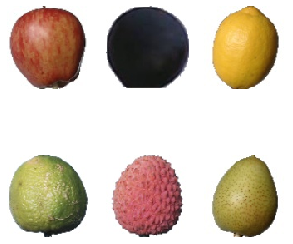

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(5,5))
    
n = 0
for i in range(0, 2):
    for j in range(0, 3):
        axs[i, j].imshow(img_arr[n], interpolation = 'nearest')
        axs[i, j].axis('off')
        n += 1  

## Train Color Features

In [5]:
# df_X = df.iloc[:, :64]
# df_X

## Train Texture Feature

In [6]:
# df_X = df.iloc[:, 64:-10]
# df_X

## Train Shape Feature

In [7]:
# df_X = df.iloc[:, -10:-1]
# df_X

## Dimension of Dataset

In [8]:
df_X.shape

(2940, 80)

## Stratified K-Fold Validation

In [9]:
# kf = KFold(n_splits=4)
# kf.get_n_splits(df_X)

# for train_index, test_index in kf.split(df_X):
#     X_train, X_test = df_X.iloc[train_index], df_X.iloc[test_index]
#     y_train, y_test = df_Y.iloc[train_index], df_Y.iloc[test_index]
# print(len(X_train), len(X_test))

## Train Test Split Model

In [10]:
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_X, df_Y, test_size=0.2, random_state=0)

## Train Random Forest Model

In [11]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train,y_train)

RandomForestClassifier()

In [12]:
y_pred = rf_model.predict(X_test)

In [16]:
clf_report_1 = pd.DataFrame(classification_report(y_test, y_pred, output_dict = True)).T
clf_report_1

,precision,recall,f1-score,support
Apple,1.0,1.0,1.0,99.0
Grape,1.0,1.0,1.0,96.0
Lemon,1.0,1.0,1.0,97.0
Limes,1.0,1.0,1.0,107.0
Lychee,1.0,1.0,1.0,96.0
Pear,1.0,1.0,1.0,93.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,588.0
weighted avg,1.0,1.0,1.0,588.0


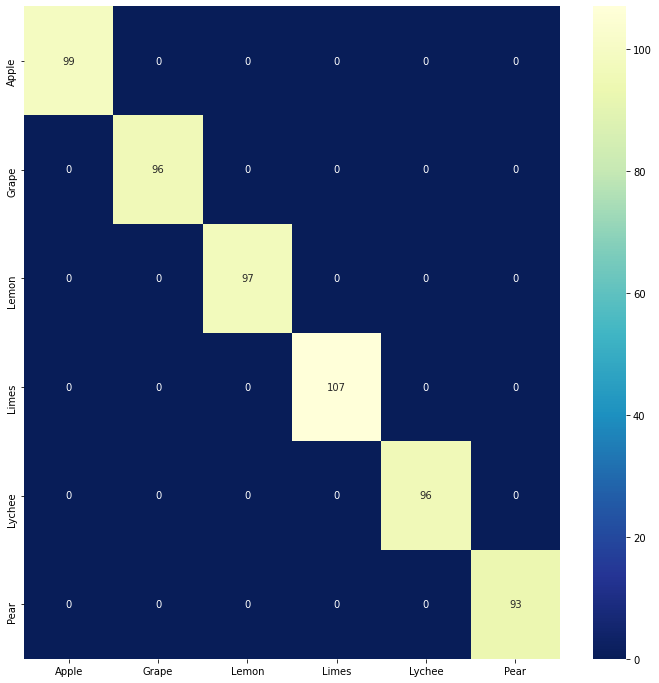

In [17]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index = sorted(df_Y.unique()), columns = sorted(df_Y.unique()))
fig = plt.figure(figsize=(12,12))

sns.heatmap(confusion_matrix_df,annot=True, fmt='g',  cmap="YlGnBu_r")
plt.show()

## Feature Importance

In [18]:
feats = {key:val for (key,val) in zip(df_X.columns, rf_model.feature_importances_)}

In [19]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', inplace = True, ascending = False)
importances = importances.iloc[:10]

<AxesSubplot:>

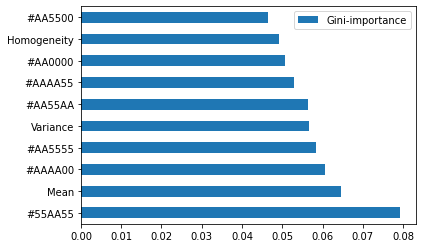

In [20]:
importances.plot(kind='barh')

## Train Support Vector Machine

In [95]:
svm_model = svm.SVC(decision_function_shape='ovo')
svm_model.fit(X_train,y_train)

SVC(decision_function_shape='ovo')

In [96]:
y_pred = svm_model.predict(X_test)

In [98]:
clf_report_2 = pd.DataFrame(classification_report(y_test, y_pred, output_dict = True)).T
clf_report_2

,precision,recall,f1-score,support
Apple,1.000000,0.939394,0.968750,99.000000
Grape,1.000000,1.000000,1.000000,96.000000
Lemon,1.000000,0.938144,0.968085,97.000000
Limes,0.980769,0.953271,0.966825,107.000000
Lychee,0.941176,1.000000,0.969697,96.000000
Pear,0.892157,0.978495,0.933333,93.000000
accuracy,0.967687,0.967687,0.967687,0.967687
macro avg,0.969017,0.968217,0.967782,588.000000
weighted avg,0.969840,0.967687,0.967945,588.000000


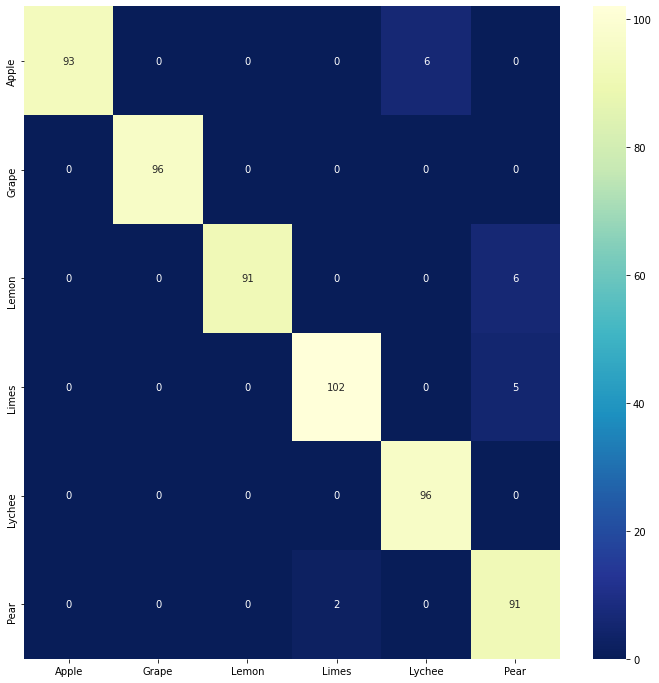

In [99]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index = sorted(df_Y.unique()), columns = sorted(df_Y.unique()))
fig = plt.figure(figsize=(12,12))

sns.heatmap(confusion_matrix_df,annot=True, fmt='g',  cmap="YlGnBu_r")
plt.show()

## Train K Nearest neighbor

In [27]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3)

In [28]:
y_pred = knn_model.predict(X_test)

In [29]:
# count=0 
# total = df_X.shape[0]
# for i in range(total):
#     check=knn_model.predict([df_X.iloc[i]])
#     if check[0] == df_Y.iloc[i] :
#         count += 1
# print(count)
# print("Accuracy is ", count/total)

In [30]:
clf_report_3 = pd.DataFrame(classification_report(y_test, y_pred, output_dict = True)).T
clf_report_3

,precision,recall,f1-score,support
Apple,1.000000,1.000000,1.000000,99.000000
Grape,1.000000,1.000000,1.000000,96.000000
Lemon,1.000000,1.000000,1.000000,97.000000
Limes,1.000000,0.981308,0.990566,107.000000
Lychee,1.000000,1.000000,1.000000,96.000000
Pear,0.978947,1.000000,0.989362,93.000000
accuracy,0.996599,0.996599,0.996599,0.996599
macro avg,0.996491,0.996885,0.996655,588.000000
weighted avg,0.996670,0.996599,0.996601,588.000000


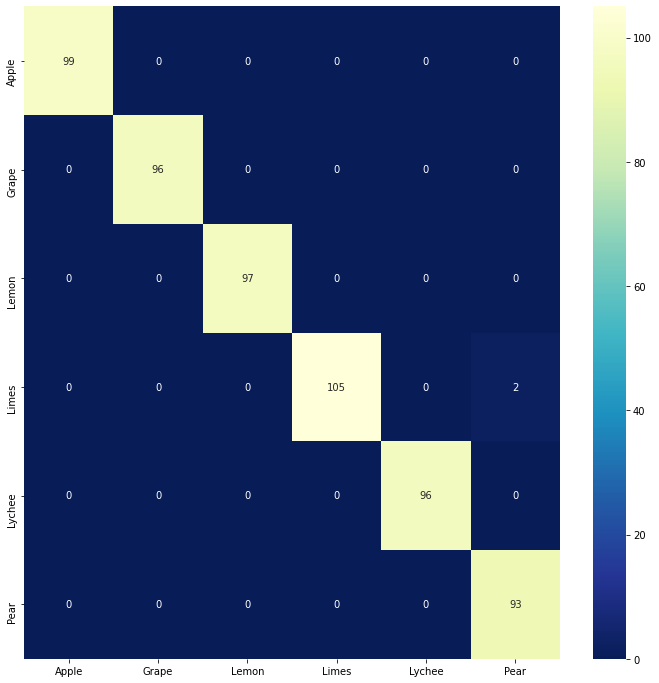

In [31]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred), index = sorted(df_Y.unique()), columns = sorted(df_Y.unique()))
fig = plt.figure(figsize=(12,12))

sns.heatmap(confusion_matrix_df,annot=True, fmt='g',  cmap="YlGnBu_r")
plt.show()

## Precision, Recall, F1-Score

In [32]:
def pfr_graph(df, x_label, y_label, title):
    df.plot.bar()
    plt.legend(bbox_to_anchor=(1, 1.05))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

In [33]:
def get_df_type(model_name, clf_report1, clf_report2, clf_report3, col_name):
    df = pd.DataFrame()
    df[model_name[0]] = clf_report1[col_name][:-3]
    df[model_name[1]] = clf_report2[col_name][:-3]
    df[model_name[2]] = clf_report3[col_name][:-3]
    
    # Replace NA value with 0
    df.fillna(0, inplace=True)
    return df

### Precision Graph

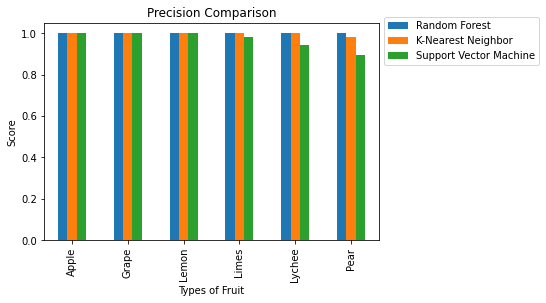

In [34]:
model_name = ["Random Forest", "K-Nearest Neighbor", "Support Vector Machine"]
df = get_df_type(model_name, clf_report_1, clf_report_3, clf_report_2, "precision")
pfr_graph(df, "Types of Fruit", "Score", "Precision Comparison")

### Recall Graph

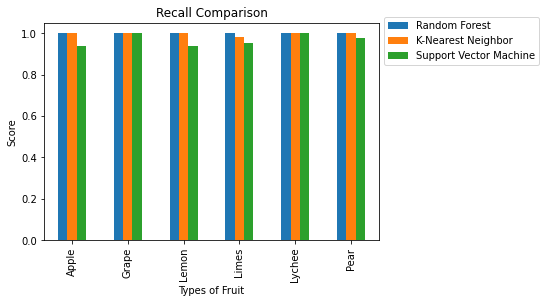

In [35]:
model_name = ["Random Forest", "K-Nearest Neighbor", "Support Vector Machine"]
df = get_df_type(model_name, clf_report_1, clf_report_3, clf_report_2, "recall")
pfr_graph(df, "Types of Fruit", "Score", "Recall Comparison")

### F1-Score Graph

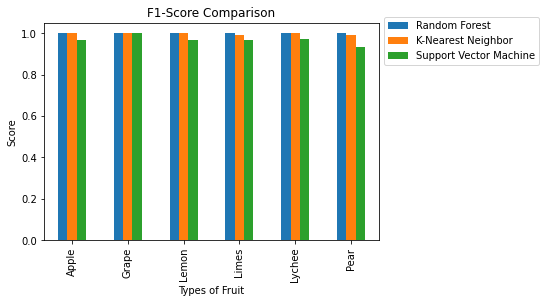

In [36]:
model_name = ["Random Forest", "K-Nearest Neighbor", "Support Vector Machine"]
df = get_df_type(model_name, clf_report_1, clf_report_3, clf_report_2, "f1-score")
pfr_graph(df, "Types of Fruit", "Score", "F1-Score Comparison")

## Precision Recall Curve

In [37]:
map_fruit_val_dict = {key:val for val, key in enumerate(sorted(df_Y.unique()))}
def map_fruit_val(x):
    arr = [0 for i in range(6)]
    arr[map_fruit_val_dict[x]] = 1
    return arr

#### Make Y_test into 2d Array

In [38]:
y_test_arr = [map_fruit_val(key) for key in y_test.to_list()]
y_test_arr = np.array(y_test_arr)

#### Make Y_Preds into 2d Array

In [39]:
y_pred = rf_model.predict(X_test)
y_pred_arr = [map_fruit_val(key) for key in y_pred]
y_pred_arr = np.array(y_pred_arr)

#### Plot Precision Recall Curve

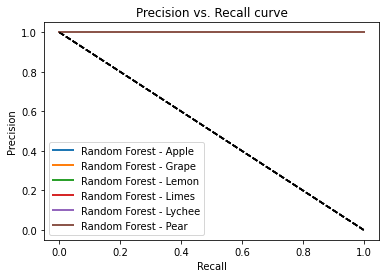

In [40]:
precision, recall = {}, {}
for ind, val in enumerate(sorted(df_Y.unique())):
    precision[ind], recall[ind], _ = precision_recall_curve(y_test_arr[:, ind], y_pred_arr[:, ind])
    plt.plot(recall[ind], precision[ind], lw=2, label=f"Random Forest - {val}")
    plt.plot(np.linspace(0, 1, 20), np.linspace(1, 0, 20), 'k--')
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc = "best")
plt.title("Precision vs. Recall curve")
plt.show()

## ROC Curve

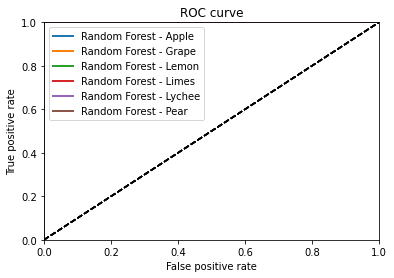

In [41]:
fpr, tpr = {}, {}
for ind, val in enumerate(sorted(df_Y.unique())):
    fpr[ind], tpr[ind], _ = roc_curve(y_test_arr[:, ind],y_pred_arr[:, ind])
    plt.plot(fpr[ind], tpr[ind], lw=2, label=f"Random Forest - {val}")
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="best")
plt.title("ROC curve")
plt.show()

## Accuracy among the three model

In [42]:
def acc_graph(model_name_arr ,acc_score_arr, x_label, y_label, title):
    acc_dict = {
        model_name: acc_score for model_name, acc_score in zip(model_name_arr, acc_score_arr)
    }
    df = pd.Series(acc_dict)
    fig, ax = plt.subplots(figsize=(12, 2))
    for ind, val in enumerate(df):
        ax.barh(ind, val, 0.5, label=df.index[ind])
        ax.text(val,ind,f"{val:.3f}%")
    plt.yticks(np.arange(len(df)),df.index)
    plt.legend(bbox_to_anchor=(1, 1.05))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

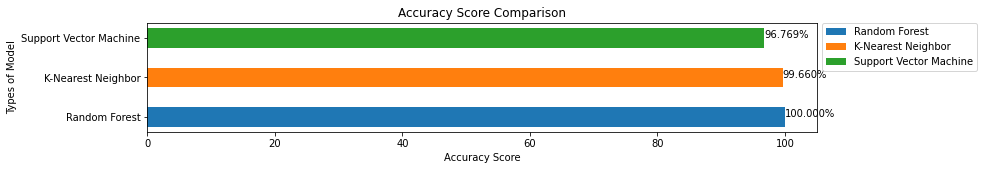

In [43]:
acc_score_arr = [accuracy_score(y_test, model.predict(X_test)) * 100.0 for model in [rf_model, knn_model, svm_model]]
model_name = ["Random Forest", "K-Nearest Neighbor", "Support Vector Machine"]
acc_graph(model_name, acc_score_arr, "Accuracy Score", "Types of Model", "Accuracy Score Comparison")

In [112]:
accuracy_report = pd.DataFrame(columns=["Accuracy"])
for (ind, acc_score) in enumerate(acc_score_arr):
    accuracy_report.loc[ind] = acc_score
accuracy_report.index = model_name
accuracy_report

,Accuracy
Random Forest,100.000000
K-Nearest Neighbor,99.659864
Support Vector Machine,96.768707


## Save Model

In [44]:
model_path = "Models\\\\"
model_arr = [rf_model, svm_model, knn_model]
filename_arr = ["random_forest", "svm","knn"]

In [45]:
for (model, filename) in zip(model_arr, filename_arr):
    pickle.dump(model, open(f"{model_path}{filename}_model.sav", 'wb'))